In [2]:
import os
import nibabel as nib
import math
import numpy as np
from tqdm import tqdm
from image_utils import *
import torch
import networks
from DegradProcess import batch_degrade, MotionDegrad
from torch import optim
import torch.nn.functional as F
import torch
import CMR_HFpEF_Analysis.Image_utils as util

gpu_id = 0
device = torch.device("cuda:{:d}".format(gpu_id) if torch.cuda.is_available() else "cpu")

ModuleNotFoundError: No module named 'torch'

### Load Ground-truth HR data

In [1]:
data_dir = '/mnt/mount_zc_NAS/HFpEF/data/processed_HR_data/154/ED/'
seg_file_path = os.path.join(data_dir, 'HR_ED_crop.nii.gz')
seg_nib = nib.load(seg_file_path)
HR_data = seg_nib.get_fdata()
HR_data = np.rollaxis(HR_data,2,0)
HR_data = np.round(HR_data)
HR_data = HR_data.astype(int)
HR_spacing = seg_nib.header.get_zooms()
HR_spacing = np.asarray([HR_spacing[-1], HR_spacing[0], HR_spacing[1]])

print(HR_data.shape,HR_spacing)

plt.figure(figsize = (12,3))
plt.subplot(131); plt.imshow(HR_data[32, ...], 'gray', aspect=HR_spacing[2] / HR_spacing[1])
plt.subplot(132); plt.imshow(HR_data[:,60, :], 'gray', aspect= HR_spacing[0] / HR_spacing[2])
plt.subplot(133); plt.imshow(HR_data[:,:,70], 'gray', aspect= HR_spacing[0] / HR_spacing[1])
# vol3view(HR_data)

NameError: name 'nib' is not defined

In [5]:
ori = util.correct_ori(HR_data)
print(ori)

50.26923076923077 79.81611374407584
wrong orientation
False


In [65]:
# check whether the data has correct orientation
for j in range(HR_data.shape[1]//2 - 14,HR_data.shape[1]):
    s = HR_data[:,j,:]
    # make sure it has RV and LV
    rv_i = np.asarray(np.where(s == 4))
    lv_i = np.asarray(np.where(s == 1))

    if (rv_i.shape[1]) == 0 or (lv_i.shape[1]) == 0:
        continue
    else:
        # compare their y axis 

        # s = HR_data[:,j,:]
        # rv_i = np.asarray(np.where(s == 4))
        # lv_i = np.asarray(np.where(s == 1))
        lv_i_x = np.mean(lv_i[1,:])
        rv_i_x = np.mean(rv_i[1,:])
        print(lv_i_x,rv_i_x)

        if rv_i_x > lv_i_x:
            print('wrong orientation')
        break

72.70833333333333 41.934510669610006


### Load degraded LR data

(13, 128, 128) [10.    1.25  1.25] 2
torch.Size([1, 4, 13, 128, 128])


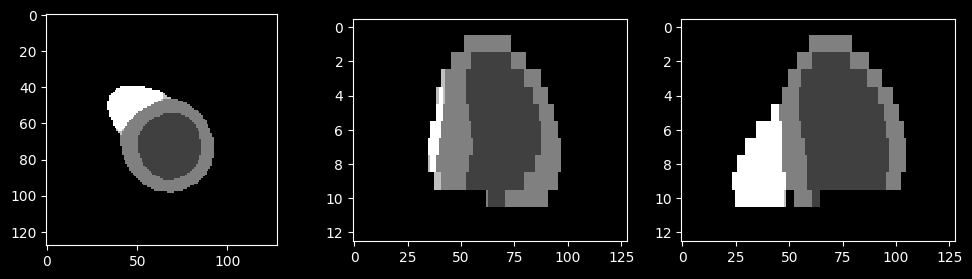

In [18]:
data_dir = '/mnt/mount_zc_NAS/HFpEF/data/simulated_data/2/ED/ds'
seg_file_path = os.path.join(data_dir, 'data.nii.gz')

seg_nib = nib.load(seg_file_path)
spacing = seg_nib.header.get_zooms()
spacing = np.asarray([spacing[-1], spacing[0], spacing[1]])
seg_data = seg_nib.get_fdata()

seg_data = np.rollaxis(seg_data,2,0)

seg_data = np.concatenate((seg_data,np.zeros((1,128,128))))

seg_data = np.round(seg_data)
seg_data = seg_data.astype(int)

plt.figure(figsize = (12,3))
plt.subplot(131); plt.imshow(seg_data[4, ...], 'gray', aspect=spacing[2] / spacing[1])
plt.subplot(132); plt.imshow(seg_data[:,64, :], 'gray', aspect=spacing[0] / spacing[2])
plt.subplot(133); plt.imshow(seg_data[:,:,70], 'gray', aspect=spacing[0] / spacing[1])

print(seg_data.shape,spacing, seg_data[4,60,50])

seg_LR = torch.Tensor(label2onehot(seg_data)[np.newaxis,:]).to(device)
print(seg_LR.shape)

# vol3view(seg_data,slices = [12,64,64])


### Load generative models of HR segmentation

In [19]:
# load model
path = '/mnt/mount_zc_NAS/HFpEF/model/SRHeart/betaVAE'
z_dim, beta = 64, 1e-3
model = networks.GenVAE3D(z_dim=z_dim, img_size=128, depth=64)
model.to(device)
# model_path = 'models/betaVAE/VAECE_zdim_{:d}_epoch_100_beta_{:.2E}_alpha.pt'.format(z_dim, beta)
model_path = os.path.join(path, 'VAECE_zdim_{:d}_epoch_100_beta_{:.2E}_alpha.pt'.format(z_dim, beta))
print(model_path)
model.load_state_dict(torch.load(model_path, map_location=device))

/mnt/mount_zc_NAS/HFpEF/model/SRHeart/betaVAE/VAECE_zdim_64_epoch_100_beta_1.00E-03_alpha.pt


<All keys matched successfully>

### Enhance the segmentation by joint motion correction and super resolution

In [20]:
new_D = seg_LR.shape[2]
MotionLayer = MotionDegrad(newD=new_D, mode='nearest')
MotionLayer.to(device)

# LATENT OPTIMISATION
z0 = torch.zeros((1, z_dim)).to(device)
seg_map = torch.argmax(seg_LR, axis=1)
print(seg_map.shape)
z_recall = z0.clone().detach().requires_grad_(True)

# optimizer for z
optimizer1 = optim.Adam([{'params': z_recall}], lr=0.2)
scheduler1 = optim.lr_scheduler.StepLR(optimizer1, step_size=100, gamma=0.5)
# optimizer for motion
optimizer2 = optim.Adam(MotionLayer.parameters(), lr=0.1)
scheduler2 = optim.lr_scheduler.StepLR(optimizer2, step_size=100, gamma=0.5)

for k in (range(0, 1000)):
    # E - step, estimate motion
    optimizer2.zero_grad()
    recon_x = model.decode(z_recall)
    recon_x = MotionLayer(recon_x)
    loss = F.cross_entropy(recon_x, seg_map,reduction='mean')
    loss.backward()
    optimizer2.step()

    # M - step, estimate z
    optimizer1.zero_grad()
    recon_x = model.decode(z_recall)
    recon_x = MotionLayer(recon_x)
    loss = F.cross_entropy(recon_x, seg_map, reduction='mean')
    loss.backward()
    optimizer1.step()

    scheduler1.step()
    scheduler2.step()

SR_data = onehot2label(model.decode(z_recall).squeeze().detach().cpu().numpy())

torch.Size([1, 13, 128, 128])


(64, 128, 128)


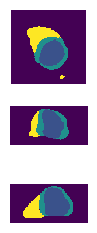

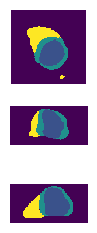

In [21]:
print(SR_data.shape)
vol3view(SR_data)

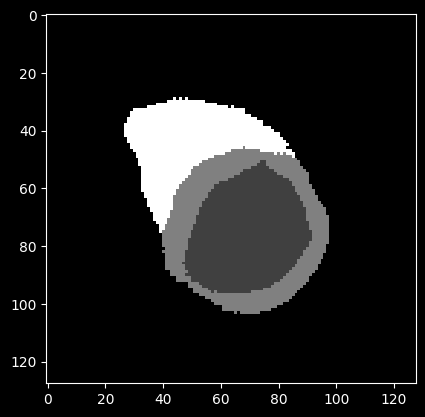

In [22]:
final_result = util.pick_largest(SR_data,[1,2,4])
SR_data = np.copy(final_result)
plt.imshow(SR_data[32, ...], 'gray', aspect=spacing[2] / spacing[1])

In [23]:
### Compare the SR result to Ground-truth HR result

HR_data = np.round(HR_data)
HR_data = HR_data.astype(int)

In [24]:
# the translated optimal dice is used because the solution to (SR_seg, d) is not unique
# eg. (HR_seg, 0) and (translated HR_seg, d) will result in the same LR seg

LV_dice, _ = np_categorical_dice_optim(SR_data, HR_data, k=1)
MYO_dice, _ = np_categorical_dice_optim(SR_data, HR_data, k=2)
RV_dice, _ = np_categorical_dice_optim(SR_data, HR_data, k=4)
print('LV DICE: {:0.2f}\nMYO DICE: {:0.2f}\nRV DICE: {:0.2f}'.format(LV_dice, MYO_dice, RV_dice))

LV DICE: 0.91
MYO DICE: 0.80
RV DICE: 0.86


In [25]:
# compare contour-to-contour distance
SR_ds = np.rollaxis(SR_data,0,3)
SR_ds = np.rollaxis(util.downsample_in_z(SR_ds,5,affine=None),2,0)
HR_ds = np.rollaxis(HR_data,0,3)
HR_ds = np.rollaxis(util.downsample_in_z(HR_ds,5,affine=None),2,0)

LR_distance,_,_ = util.c2c(seg_data, [spacing[1],spacing[2]],threshold = 1, large = False)
SR_distance,_,_ = util.c2c(SR_ds,[HR_spacing[1],HR_spacing[2]], threshold = 1, large = False)
HR_distance,_,_ = util.c2c(HR_ds,[HR_spacing[1],HR_spacing[2]], threshold = 1, large = False)

print(LR_distance,SR_distance,HR_distance)

4.007834035445748 3.038510294801648 4.007834035445748


/usr/local/lib/python3.8/dist-packages/scipy/ndimage/measurements.py:1406: RuntimeWarning: invalid value encountered in double_scalars
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


In [21]:
# distance in SR dta
centers_SR = []; distance_SR = []
for i in range(0,SR_data.shape[0]):
    s = SR_data[i,:,:]
    center = util.center_of_mass(s,1,large = False)
    if math.isnan(center[0]) == 0:
        centers_SR.append(center)
        if len(centers_SR) > 1:
            distance_SR.append(math.sqrt((centers_SR[-1][0] - centers_SR[-2][0])**2 + (centers_SR[-1][1] - centers_SR[-2][1])**2))
print(len(centers_SR),len(distance_SR))
print(sum(distance_SR) / len(distance_SR))

52 51
0.9181515515369364


/usr/local/lib/python3.8/dist-packages/scipy/ndimage/measurements.py:1406: RuntimeWarning: invalid value encountered in double_scalars
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


In [22]:
# distance in SR dta
centers_SR = []; distance_SR = []
for i in range(0,HR_data.shape[0]):
    s = HR_data[i,:,:]
    center = util.center_of_mass(s,1,large = False)
    if math.isnan(center[0]) == 0:
        centers_SR.append(center)
        if len(centers_SR) > 1:
            distance_SR.append(math.sqrt((centers_SR[-1][0] - centers_SR[-2][0])**2 + (centers_SR[-1][1] - centers_SR[-2][1])**2))
print(len(centers_SR),len(distance_SR))
print(sum(distance_SR) / len(distance_SR))

46 45
0.6540953195773155
